# TA-14 — Implementasi Ensemble Learning dengan XGBoost  
**Studi kasus:** Prediksi Risiko Penyakit Jantung (Heart Disease)  
**Tipe masalah:** Klasifikasi biner (target 0/1)  

> Catatan: Notebook ini disusun mengikuti materi Modul 14 (XGBoost) dan ketentuan TA-14:  
> - EDA (cek imbalance & korelasi)  
> - Preprocessing (encoding + missing values strategy)  
> - Baseline model + XGBoost baseline  
> - (Opsional) handling imbalance via `scale_pos_weight`  
> - Hyperparameter tuning (GridSearchCV)  
> - Evaluasi: Confusion Matrix, Classification Report, ROC-AUC curve  
> - **Feature Importance (WAJIB)** (termasuk `xgboost.plot_importance`)  


In [8]:
# Jika belum terpasang, jalankan:
# !pip -q install xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, RocCurveDisplay
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

import joblib

RANDOM_STATE = 42


## 1. Load Dataset


In [9]:
# Sesuaikan path bila perlu
DATA_PATH = "heart.csv"  # jika file berada di folder yang sama dengan notebook
# DATA_PATH = "/mnt/data/heart.csv"  # (opsional) path di environment ini

df = pd.read_csv(DATA_PATH)
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [10]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.info()


Shape: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### 1.1 Cek Missing Values


In [11]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]


Series([], dtype: int64)

## 2. Exploratory Data Analysis (EDA)
### 2.1 Distribusi Target (Cek Imbalance)


Target counts:
 target
0    138
1    165
Name: count, dtype: int64

Target ratio (%):
 target
0    45.54
1    54.46
Name: count, dtype: float64


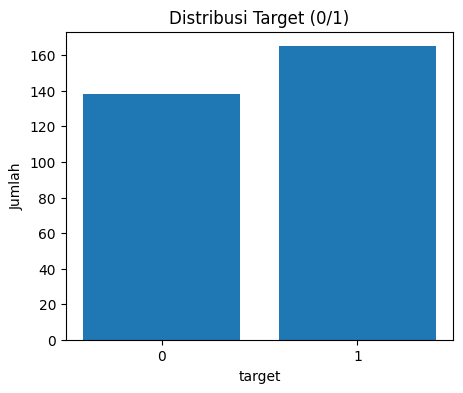


scale_pos_weight (neg/pos): 0.8364


In [12]:
target_counts = df["target"].value_counts().sort_index()
target_ratio = target_counts / len(df)

print("Target counts:\n", target_counts)
print("\nTarget ratio (%):\n", (target_ratio * 100).round(2))

plt.figure(figsize=(5,4))
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title("Distribusi Target (0/1)")
plt.xlabel("target")
plt.ylabel("Jumlah")
plt.show()

# hitung rasio scale_pos_weight (opsional untuk handling imbalance)
neg = target_counts.get(0, 0)
pos = target_counts.get(1, 0)
scale_pos_weight = neg / pos if pos != 0 else 1.0
print("\nscale_pos_weight (neg/pos):", round(scale_pos_weight, 4))


### 2.2 Statistik Deskriptif


In [13]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


### 2.3 Korelasi Antar Fitur (Heatmap)


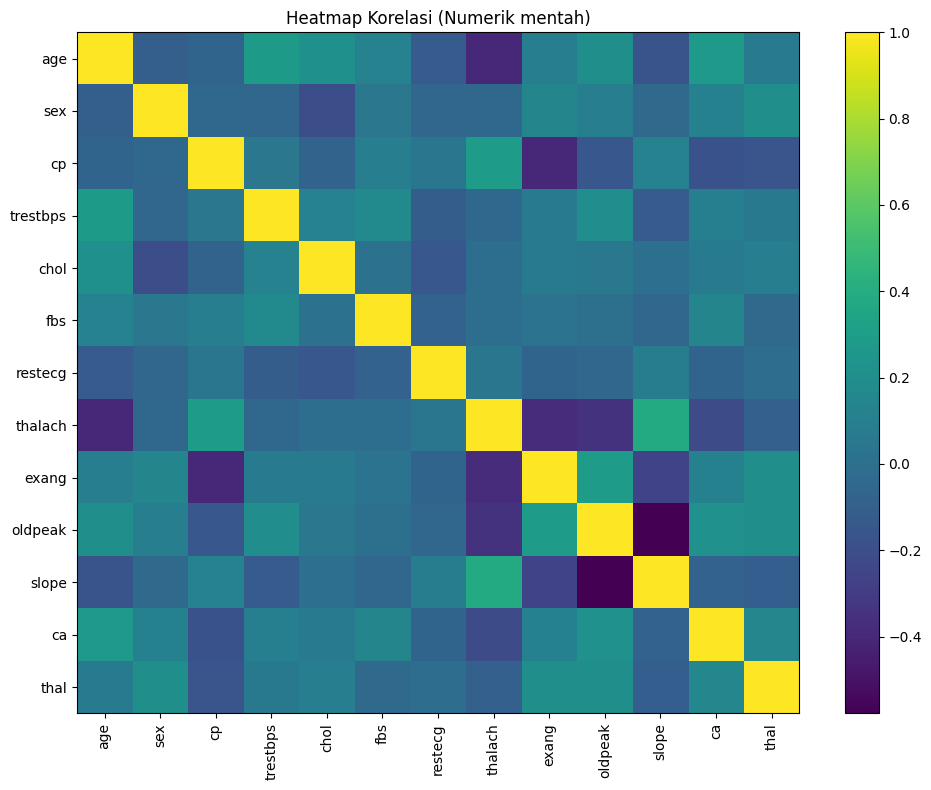

In [14]:
# Korelasi dihitung pada representasi numerik di dataset (sebagian fitur sebenarnya kategorikal).
corr = df.drop(columns=["target"]).corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Heatmap Korelasi (Numerik mentah)")
plt.tight_layout()
plt.show()


## 3. Preprocessing Data
### 3.1 Definisi X dan y


In [15]:
X = df.drop(columns=["target"])
y = df["target"]

X.head(), y.head()


(   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
 0   63    1   3       145   233    1        0      150      0      2.3      0   
 1   37    1   2       130   250    0        1      187      0      3.5      0   
 2   41    0   1       130   204    0        0      172      0      1.4      2   
 3   56    1   1       120   236    0        1      178      0      0.8      2   
 4   57    0   0       120   354    0        1      163      1      0.6      2   
 
    ca  thal  
 0   0     1  
 1   0     2  
 2   0     2  
 3   0     2  
 4   0     2  ,
 0    1
 1    1
 2    1
 3    1
 4    1
 Name: target, dtype: int64)

### 3.2 Encoding  
Untuk aman sesuai ketentuan tugas, fitur kategorikal kita **One-Hot Encode**.  
> Catatan: Karena XGBoost berbasis pohon, **tidak perlu Standard Scaling**.


In [16]:
# Tentukan fitur kategorikal vs numerik
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
numeric_features = [c for c in X.columns if c not in categorical_features]

print("Categorical:", categorical_features)
print("Numeric:", numeric_features)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)


Categorical: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Numeric: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


### 3.3 Train-Test Split (80/20, Stratify)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train target ratio:\n", (y_train.value_counts(normalize=True)*100).round(2))
print("Test target ratio:\n", (y_test.value_counts(normalize=True)*100).round(2))


Train: (242, 13) Test: (61, 13)
Train target ratio:
 target
1    54.55
0    45.45
Name: proportion, dtype: float64
Test target ratio:
 target
1    54.1
0    45.9
Name: proportion, dtype: float64


## 4. Baseline Model Pembanding (Model Tunggal)


In [18]:
def evaluate_binary_classifier(model, X_test, y_test, title="Model"):
    """Cetak metrik dan tampilkan confusion matrix + ROC curve."""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    print(f"=== {title} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")
    print()

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix — {title}")
    plt.show()

    if y_prob is not None:
        RocCurveDisplay.from_predictions(y_test, y_prob)
        plt.title(f"ROC Curve — {title}")
        plt.show()

    return {"Model": title, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "ROC_AUC": auc}


=== Decision Tree ===
Accuracy : 0.7377
Precision: 0.7429
Recall   : 0.7879
F1-score : 0.7647
ROC-AUC  : 0.7332

Classification Report:
              precision    recall  f1-score   support

           0     0.7308    0.6786    0.7037        28
           1     0.7429    0.7879    0.7647        33

    accuracy                         0.7377        61
   macro avg     0.7368    0.7332    0.7342        61
weighted avg     0.7373    0.7377    0.7367        61



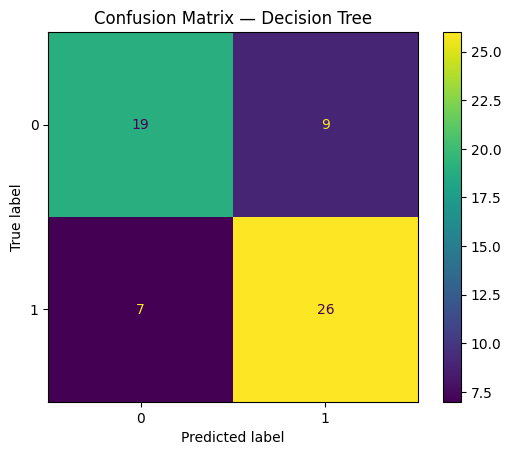

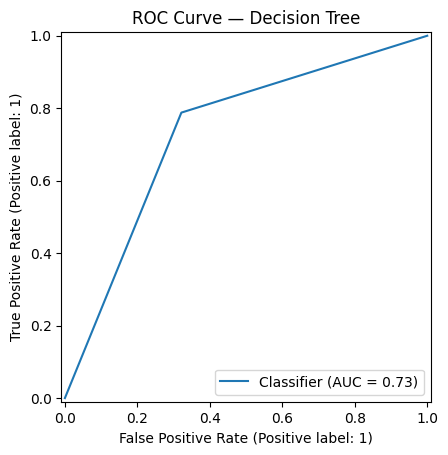

In [19]:
# Baseline 1: Decision Tree (single model)
dt_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

dt_pipeline.fit(X_train, y_train)
dt_metrics = evaluate_binary_classifier(dt_pipeline, X_test, y_test, title="Decision Tree")


=== Logistic Regression ===
Accuracy : 0.8689
Precision: 0.8571
Recall   : 0.9091
F1-score : 0.8824
ROC-AUC  : 0.9102

Classification Report:
              precision    recall  f1-score   support

           0     0.8846    0.8214    0.8519        28
           1     0.8571    0.9091    0.8824        33

    accuracy                         0.8689        61
   macro avg     0.8709    0.8653    0.8671        61
weighted avg     0.8698    0.8689    0.8684        61



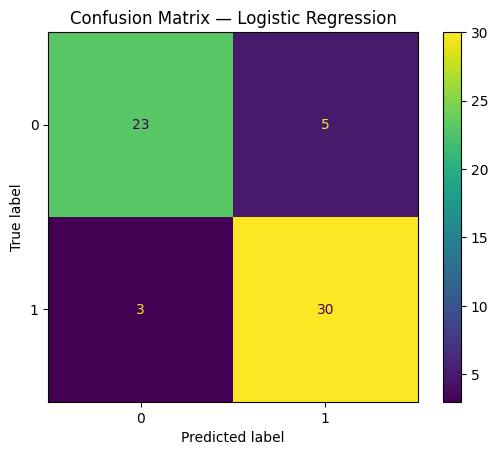

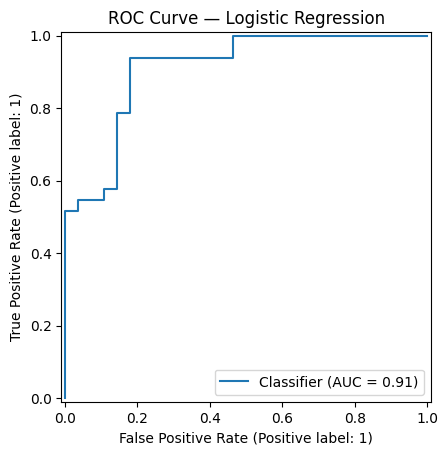

In [20]:
# Baseline 2: Logistic Regression (linear)
lr_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

lr_pipeline.fit(X_train, y_train)
lr_metrics = evaluate_binary_classifier(lr_pipeline, X_test, y_test, title="Logistic Regression")


## 5. XGBoost — Baseline Model (Default-ish)


=== XGBoost (Baseline) ===
Accuracy : 0.7869
Precision: 0.7632
Recall   : 0.8788
F1-score : 0.8169
ROC-AUC  : 0.8561

Classification Report:
              precision    recall  f1-score   support

           0     0.8261    0.6786    0.7451        28
           1     0.7632    0.8788    0.8169        33

    accuracy                         0.7869        61
   macro avg     0.7946    0.7787    0.7810        61
weighted avg     0.7920    0.7869    0.7839        61



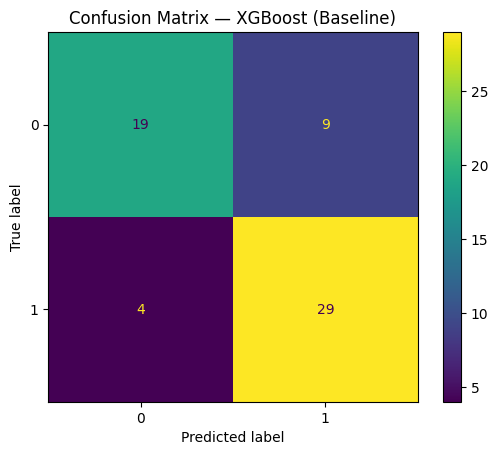

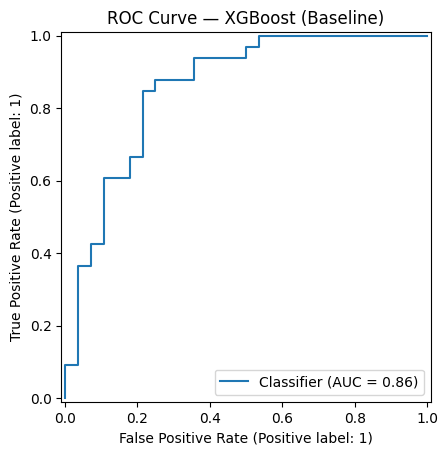

In [21]:
# Baseline XGBoost
xgb_baseline = XGBClassifier(
    random_state=RANDOM_STATE,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    eval_metric="logloss",
    tree_method="hist"  # cepat untuk data tabular
)

xgb_baseline_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_baseline)
])

xgb_baseline_pipeline.fit(X_train, y_train)
xgb_base_metrics = evaluate_binary_classifier(xgb_baseline_pipeline, X_test, y_test, title="XGBoost (Baseline)")


## 6. (Opsional) Handling Imbalance dengan `scale_pos_weight`


=== XGBoost (scale_pos_weight) ===
Accuracy : 0.8033
Precision: 0.7692
Recall   : 0.9091
F1-score : 0.8333
ROC-AUC  : 0.8550

Classification Report:
              precision    recall  f1-score   support

           0     0.8636    0.6786    0.7600        28
           1     0.7692    0.9091    0.8333        33

    accuracy                         0.8033        61
   macro avg     0.8164    0.7938    0.7967        61
weighted avg     0.8126    0.8033    0.7997        61



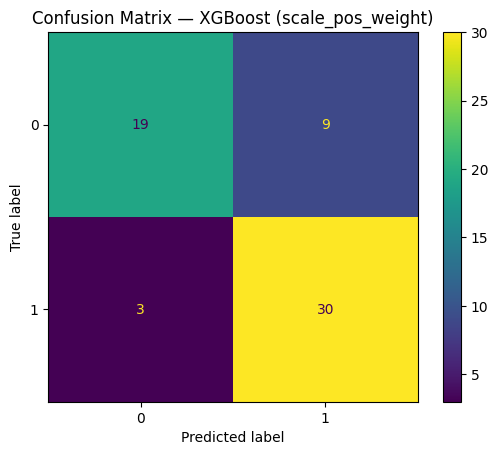

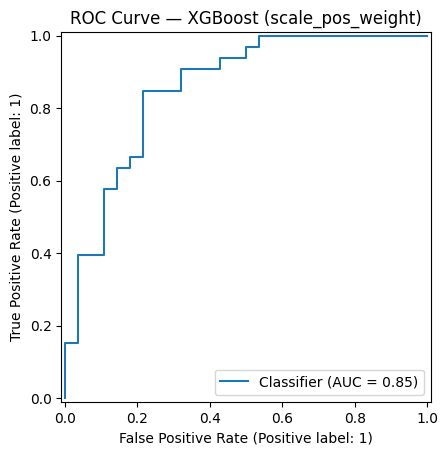

In [22]:
xgb_spw = XGBClassifier(
    random_state=RANDOM_STATE,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight
)

xgb_spw_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_spw)
])

xgb_spw_pipeline.fit(X_train, y_train)
xgb_spw_metrics = evaluate_binary_classifier(xgb_spw_pipeline, X_test, y_test, title="XGBoost (scale_pos_weight)")


## 7. Hyperparameter Tuning (GridSearchCV)


In [23]:
xgb_for_tuning = XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric="logloss",
    tree_method="hist"
)

tuning_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_for_tuning)
])

param_grid = {
    "model__max_depth": [2, 3, 4, 5],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__n_estimators": [100, 200, 300, 500],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=tuning_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best ROC-AUC (CV):", grid.best_score_)
print("Best params:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best ROC-AUC (CV): 0.8938357938357939
Best params:
  model__colsample_bytree: 0.8
  model__learning_rate: 0.05
  model__max_depth: 4
  model__n_estimators: 100
  model__subsample: 0.8


### 7.1 Evaluasi Model Terbaik di Data Test


=== XGBoost (Tuned Best) ===
Accuracy : 0.7869
Precision: 0.7632
Recall   : 0.8788
F1-score : 0.8169
ROC-AUC  : 0.8853

Classification Report:
              precision    recall  f1-score   support

           0     0.8261    0.6786    0.7451        28
           1     0.7632    0.8788    0.8169        33

    accuracy                         0.7869        61
   macro avg     0.7946    0.7787    0.7810        61
weighted avg     0.7920    0.7869    0.7839        61



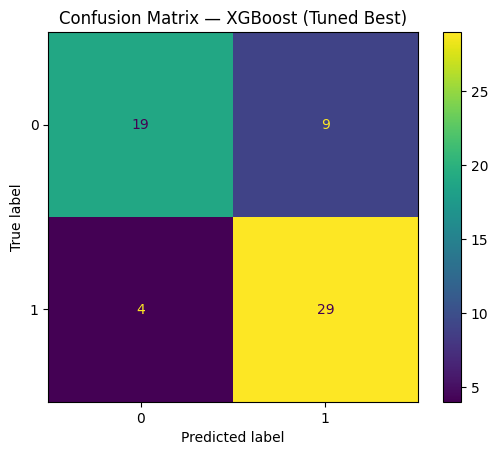

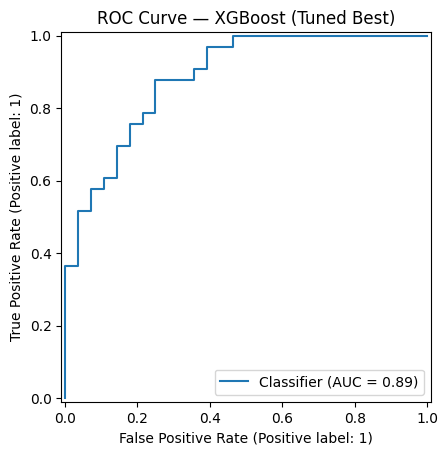

In [24]:
best_model = grid.best_estimator_
best_metrics = evaluate_binary_classifier(best_model, X_test, y_test, title="XGBoost (Tuned Best)")


## 8. Perbandingan Ringkas Semua Model


In [25]:
results = pd.DataFrame([dt_metrics, lr_metrics, xgb_base_metrics, xgb_spw_metrics, best_metrics])
results.sort_values(by="ROC_AUC", ascending=False)


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
1,Logistic Regression,0.868852,0.857143,0.909091,0.882353,0.910173
4,XGBoost (Tuned Best),0.786885,0.763158,0.878788,0.816901,0.885281
2,XGBoost (Baseline),0.786885,0.763158,0.878788,0.816901,0.856061
3,XGBoost (scale_pos_weight),0.803279,0.769231,0.909091,0.833333,0.854978
0,Decision Tree,0.737705,0.742857,0.787879,0.764706,0.733225


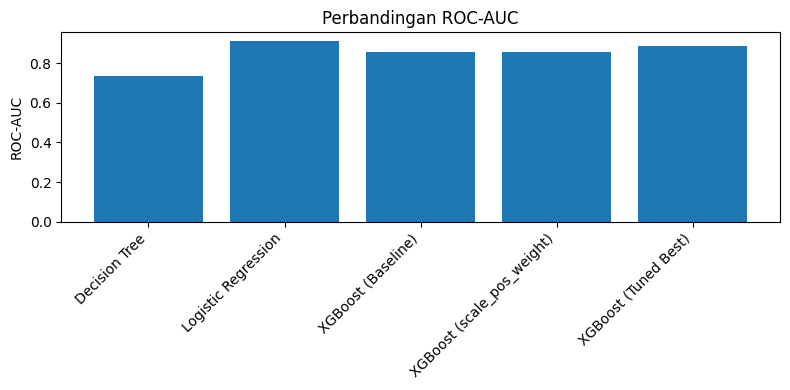

In [26]:
plt.figure(figsize=(8,4))
plt.bar(results["Model"], results["ROC_AUC"])
plt.xticks(rotation=45, ha="right")
plt.title("Perbandingan ROC-AUC")
plt.ylabel("ROC-AUC")
plt.tight_layout()
plt.show()


## 9. Feature Importance (WAJIB)


<Figure size 1000x600 with 0 Axes>

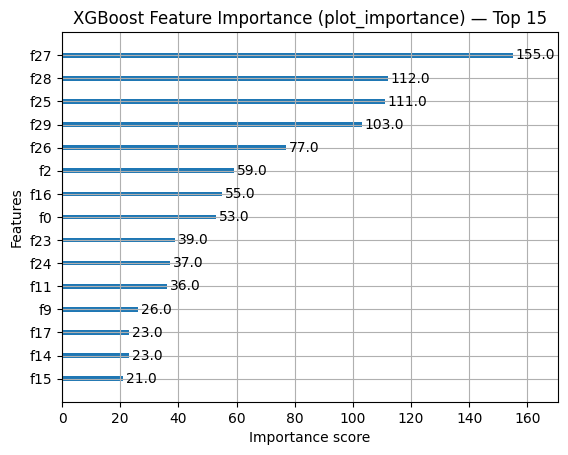

In [27]:
# Ambil model XGBClassifier dari pipeline terbaik
xgb_best = best_model.named_steps["model"]

# 1) plot_importance bawaan XGBoost
plt.figure(figsize=(10,6))
plot_importance(xgb_best, max_num_features=15)
plt.title("XGBoost Feature Importance (plot_importance) — Top 15")
plt.show()


In [28]:
# 2) Feature importance dengan nama fitur hasil preprocessing (sklearn)
pre = best_model.named_steps["preprocess"]
feature_names = pre.get_feature_names_out()

importances = xgb_best.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fi.head(20)


cat__thal_2       0.216016
cat__cp_0         0.090040
cat__slope_0      0.067409
cat__exang_1      0.062424
cat__slope_2      0.058120
cat__exang_0      0.042812
cat__ca_0         0.042241
cat__cp_3         0.036061
num__oldpeak      0.035264
cat__thal_3       0.033861
cat__cp_2         0.028137
cat__ca_1         0.027804
cat__restecg_1    0.026557
cat__slope_1      0.026008
cat__sex_1        0.024717
cat__sex_0        0.024005
num__chol         0.023849
num__age          0.021145
cat__ca_2         0.020591
cat__restecg_0    0.019281
dtype: float32

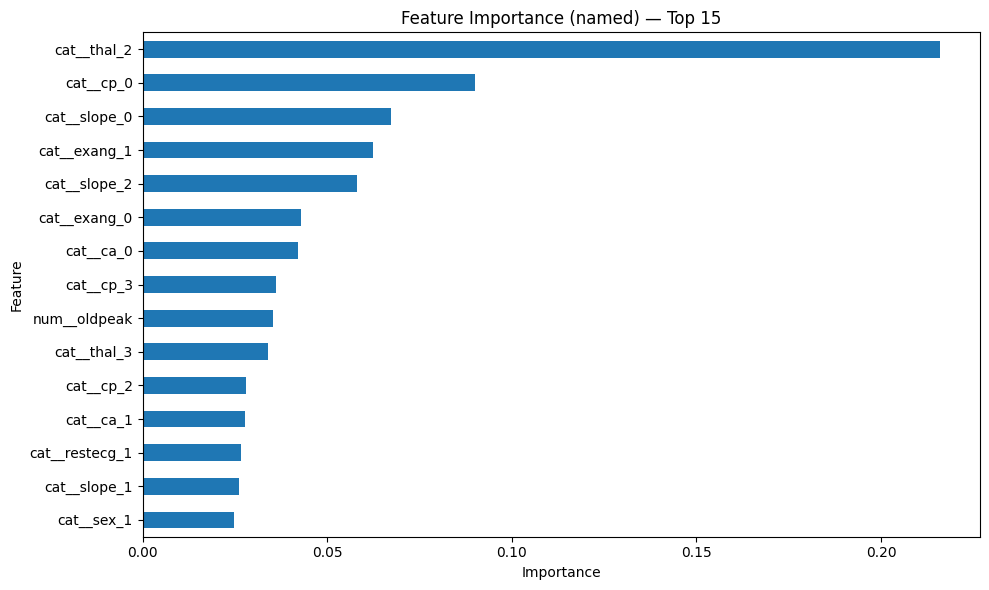

In [29]:
plt.figure(figsize=(10,6))
fi.head(15).sort_values().plot(kind="barh")
plt.title("Feature Importance (named) — Top 15")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## 10. Prediksi Data Baru (Demo)


In [30]:
# Contoh: ambil 1 baris dari data test sebagai 'data baru'
sample = X_test.iloc[[0]].copy()
print("Sample input:")
display(sample)

pred = best_model.predict(sample)[0]
prob = best_model.predict_proba(sample)[0, 1]

print(f"Prediksi kelas: {pred} (0=tidak berisiko, 1=berisiko)")
print(f"Probabilitas kelas 1: {prob:.4f}")


Sample input:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
179,57,1,0,150,276,0,0,112,1,0.6,1,1,1


Prediksi kelas: 0 (0=tidak berisiko, 1=berisiko)
Probabilitas kelas 1: 0.0608


## 11. Simpan Model untuk Deployment


In [31]:
# Simpan pipeline lengkap (preprocess + model)
MODEL_PATH = "xgb_heart_pipeline.joblib"
joblib.dump(best_model, MODEL_PATH)

print("Saved model to:", MODEL_PATH)


Saved model to: xgb_heart_pipeline.joblib
